# Capstone Project
# Customer Satisfaction

##  1. Tóm tắt và hiểu dữ liệu

### Import

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Cấu hình hiển thị đẹp
sns.set(style="whitegrid")

In [56]:
# Đọc dữ liệu
df = pd.read_csv("../Data/Train_clean.csv")

# Chuyển cột thời gian sang kiểu datetime
date_cols = [
    "Date_Registered", "payment_datetime", "purchased_datetime",
    "released_date", "estimated_delivery_date", "received_date"
]
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

# Thêm cột số ngày giao hàng
df["delivery_duration"] = (df["received_date"] - df["released_date"]).dt.days

# Kích thước dữ liệu
print(df.shape)


(205255, 23)


In [55]:
print(df.info())            # Thông tin kiểu dữ liệu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205255 entries, 0 to 205254
Data columns (total 23 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   age                                  205255 non-null  int64         
 1   Gender                               205255 non-null  object        
 2   Date_Registered                      205255 non-null  datetime64[ns]
 3   Is_current_loyalty_program_member    205255 non-null  object        
 4   loyalty_points_redeemed              205255 non-null  int64         
 5   loyalty_tier                         205255 non-null  float64       
 6   Received_tier_discount_percentage    205255 non-null  float64       
 7   Received_card_discount_percentage    205255 non-null  float64       
 8   Received_coupon_discount_percentage  205255 non-null  int64         
 9   product_category                     205255 non-null  object        
 

In [16]:
# Kiểm tra kiểu dữ liệu
print(df.dtypes)

age                                             int64
Gender                                         object
Date_Registered                        datetime64[ns]
Is_current_loyalty_program_member              object
loyalty_points_redeemed                         int64
loyalty_tier                                  float64
Received_tier_discount_percentage             float64
Received_card_discount_percentage             float64
Received_coupon_discount_percentage             int64
product_category                               object
Product_value                                   int64
payment_method                                 object
payment_datetime                       datetime64[ns]
purchased_datetime                     datetime64[ns]
purchase_medium                                object
final_payment                                 float64
released_date                          datetime64[ns]
estimated_delivery_date                datetime64[ns]
received_date               

In [15]:
# Kiểm tra giá trị thiếu
print(df.isnull().sum())

age                                       0
Gender                                    0
Date_Registered                           0
Is_current_loyalty_program_member         0
loyalty_points_redeemed                   0
loyalty_tier                              0
Received_tier_discount_percentage         0
Received_card_discount_percentage         0
Received_coupon_discount_percentage       0
product_category                          0
Product_value                             0
payment_method                            0
payment_datetime                          0
purchased_datetime                        0
purchase_medium                           0
final_payment                             0
released_date                             0
estimated_delivery_date                   0
received_date                             0
shipping_method                           0
customer_experience                       0
Age-Group                              1289
dtype: int64


In [21]:
# Kiểm tra các giá trị duy nhất của cột Age-Group
df["Age-Group"].unique()


array(['Middle', 'Elderly', 'Adult', 'Teenager', nan], dtype=object)

### Bổ sung Age-group thiếu

In [58]:
# Kiểm tra những Age-Group đã có trong dữ liệu
existing_groups = df["Age-Group"].dropna().unique()
print("Các nhóm tuổi đã có:", existing_groups)


Các nhóm tuổi đã có: ['Middle' 'Elderly' 'Adult' 'Teenager']


In [26]:
# Kiểm tra phân phối độ tuổi trong các nhóm tuổi đã có
age_group_distribution = df.groupby("Age-Group")["age"].describe()
print(age_group_distribution)

             count       mean       std   min   25%   50%   75%   max
Age-Group                                                            
Adult      46740.0  25.493325  2.866317  21.0  23.0  25.0  28.0  30.0
Elderly    70643.0  52.998485  4.323098  46.0  49.0  53.0  57.0  60.0
Middle     70970.0  37.988869  4.307348  31.0  34.0  38.0  42.0  45.0
Teenager   15613.0  19.074681  0.825737  18.0  18.0  19.0  20.0  20.0


In [48]:
# Hàm phân loại độ tuổi (sử dụng phân phối độ tuổi đã có)
def categorize_age_based_on_existing(age, existing_groups, df):
    # Tính toán độ tuổi trung bình của các nhóm tuổi đã có
    group_averages = df.groupby("Age-Group")["age"].mean()
    
    # Phân loại độ tuổi vào nhóm gần nhất
    closest_group = min(existing_groups, key=lambda group: abs(group_averages[group] - age))
    return closest_group

# Dự đoán Age-Group cho các dòng thiếu
df["Age-Group"] = df.apply(lambda row: categorize_age_based_on_existing(row["age"], existing_groups, df) 
                           if pd.isnull(row["Age-Group"]) else row["Age-Group"], axis=1)

# Kiểm tra xem còn thiếu giá trị không
print(df["Age-Group"].isnull().sum())



0


### Thống kê mô tả

In [52]:
# Thống kê mô tả
print(df.describe(include='all'))

                  age  Gender Date_Registered  \
count   205255.000000  205255          205255   
unique            NaN       3            1823   
top               NaN  Female      2021-09-18   
freq              NaN   68796             172   
mean        38.632009     NaN             NaN   
std         12.795541     NaN             NaN   
min          0.000000     NaN             NaN   
25%         28.000000     NaN             NaN   
50%         39.000000     NaN             NaN   
75%         50.000000     NaN             NaN   
max         60.000000     NaN             NaN   

       Is_current_loyalty_program_member  loyalty_points_redeemed  \
count                             205255            205255.000000   
unique                                 2                      NaN   
top                                  YES                      NaN   
freq                              102763                      NaN   
mean                                 NaN                 2.473192 

## 2. Phân tích đơn biến (Univariate Analysis)

In [65]:
# Kiểm tra số lượng giá trị duy nhất và tần suất
print(df['customer_experience'].value_counts())

customer_experience
good       89678
bad        68535
neutral    47042
Name: count, dtype: int64


#### 2.1. Phân tích sự hài lòng của khách hàng

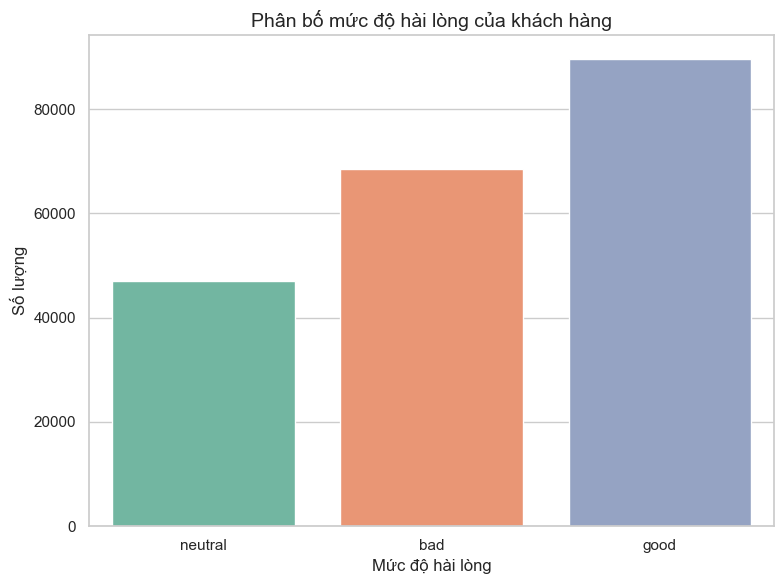

In [110]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='customer_experience',
              hue='customer_experience',
              palette='Set2',
              legend=False)  # Không cần hiển thị chú thích

plt.title('Phân bố mức độ hài lòng của khách hàng', fontsize=14)
plt.xlabel('Mức độ hài lòng')
plt.ylabel('Số lượng')
plt.tight_layout()
plt.show()


Nhận xét về mức độ hài lòng của khách hàng
Phần lớn khách hàng đánh giá trải nghiệm là "good":

- Chiếm khoảng 43.7% tổng số lượt đánh giá.

- Đây là một tín hiệu tích cực cho sàn thương mại điện tử, cho thấy phần lớn khách hàng có trải nghiệm tốt.

Tỷ lệ khách hàng không hài lòng ("bad") vẫn đáng kể:

- Với hơn 68,000 lượt đánh giá không hài lòng (33.4%), đây là con số không nhỏ.

- Cần điều tra thêm: những yếu tố nào khiến khách hàng không hài lòng? Ví dụ: giao hàng trễ, sản phẩm không đúng, dịch vụ chăm sóc khách hàng kém...

Nhóm "neutral" thấp nhất (22.9%):

- Khách hàng trong nhóm này có thể dễ bị chuyển thành “bad” nếu không có cải thiện dịch vụ — đây là nhóm nên tập trung chuyển hóa thành "good".

#### 2.1. Phân tích độ hài lòng theo giới tính:

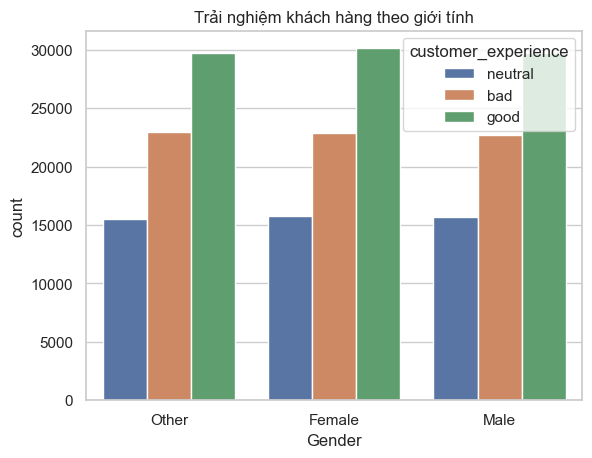

In [111]:
sns.countplot(data=df, x='Gender', hue='customer_experience')
plt.title("Trải nghiệm khách hàng theo giới tính")
plt.show()


#### 2.3. Phân tích theo độ tuổi:

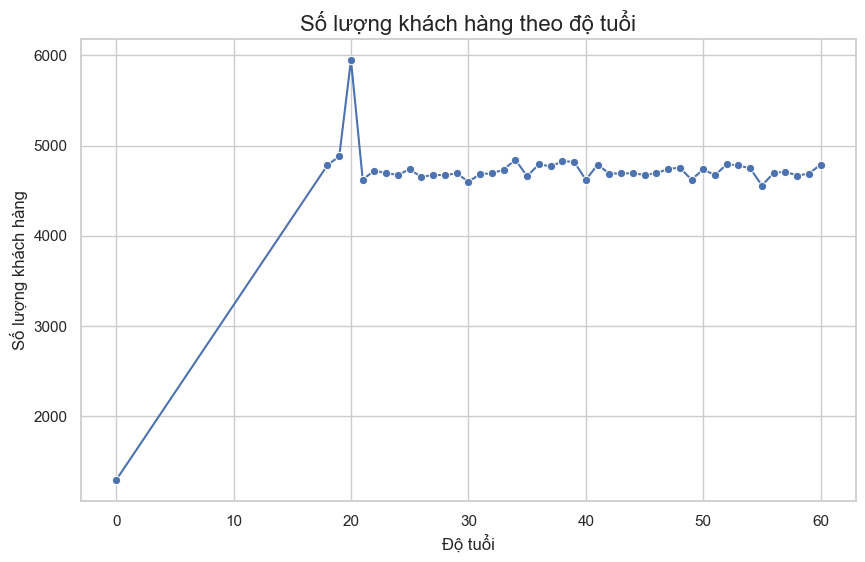

In [112]:
# Nhóm theo độ tuổi và đếm số lượng khách hàng trong mỗi nhóm
age_group_counts = df['age'].value_counts().sort_index()

# Vẽ biểu đồ đường
plt.figure(figsize=(10, 6))
sns.lineplot(x=age_group_counts.index, y=age_group_counts.values, marker='o')

# Thêm tiêu đề và nhãn cho trục
plt.title('Số lượng khách hàng theo độ tuổi', fontsize=16)
plt.xlabel('Độ tuổi', fontsize=12)
plt.ylabel('Số lượng khách hàng', fontsize=12)

# Hiển thị biểu đồ
plt.grid(True)
plt.show()

#### 2.4. Trung bình giá trị sản phẩm theo trải nghiệm khách hàng

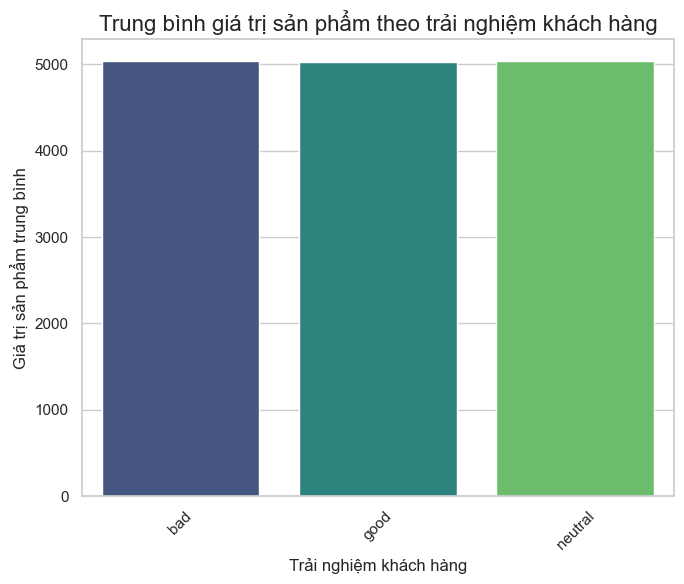

In [113]:
# Tính toán trung bình của 'Product_value' theo 'customer_experience'
avg_product_value = df.groupby('customer_experience')['Product_value'].mean().reset_index()

# Vẽ biểu đồ cột và sử dụng `hue` để chỉ định phân nhóm theo 'customer_experience'
plt.figure(figsize=(7, 6))
sns.barplot(x='customer_experience', y='Product_value', data=avg_product_value, hue='customer_experience', palette='viridis')

# Thêm tiêu đề và nhãn cho trục
plt.title('Trung bình giá trị sản phẩm theo trải nghiệm khách hàng', fontsize=16)
plt.xlabel('Trải nghiệm khách hàng', fontsize=12)
plt.ylabel('Giá trị sản phẩm trung bình', fontsize=12)

# Hiển thị biểu đồ
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Giá trị sản phẩm theo độ tuổi

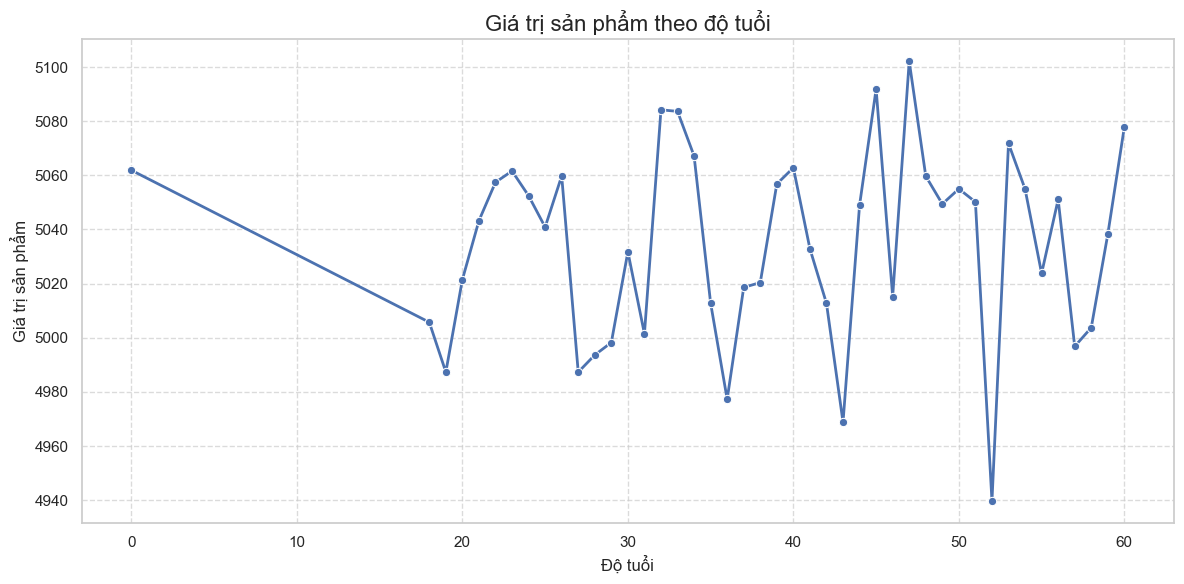

In [114]:
# Tính giá trị trung bình của 'Product_value' theo 'age'
age_product_value = df.groupby('age')['Product_value'].mean().reset_index()

# Vẽ biểu đồ đường
plt.figure(figsize=(12, 6))
sns.lineplot(x='age', y='Product_value', data=age_product_value, marker='o', color='b', linewidth=2)

# Thêm tiêu đề và nhãn cho trục
plt.title('Giá trị sản phẩm theo độ tuổi', fontsize=16)
plt.xlabel('Độ tuổi', fontsize=12)
plt.ylabel('Giá trị sản phẩm', fontsize=12)

# Hiển thị biểu đồ
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Trung bình giá trị sản phẩm theo kênh mua hàng

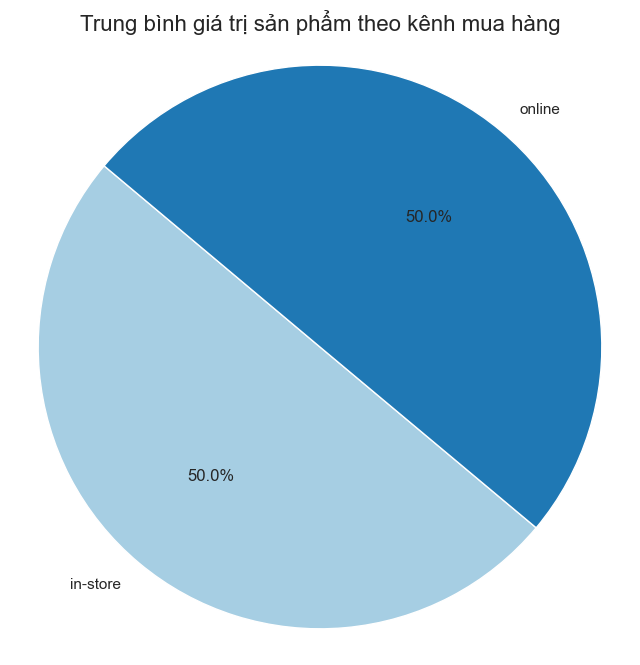

In [115]:
# Tính toán giá trị trung bình của 'Product_value' theo 'purchase_medium'
avg_product_value_by_medium = df.groupby('purchase_medium')['Product_value'].mean()

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 8))
plt.pie(avg_product_value_by_medium, labels=avg_product_value_by_medium.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

# Thêm tiêu đề
plt.title('Trung bình giá trị sản phẩm theo kênh mua hàng', fontsize=16)

# Hiển thị biểu đồ
plt.axis('equal')  # Đảm bảo biểu đồ tròn là tròn
plt.show()

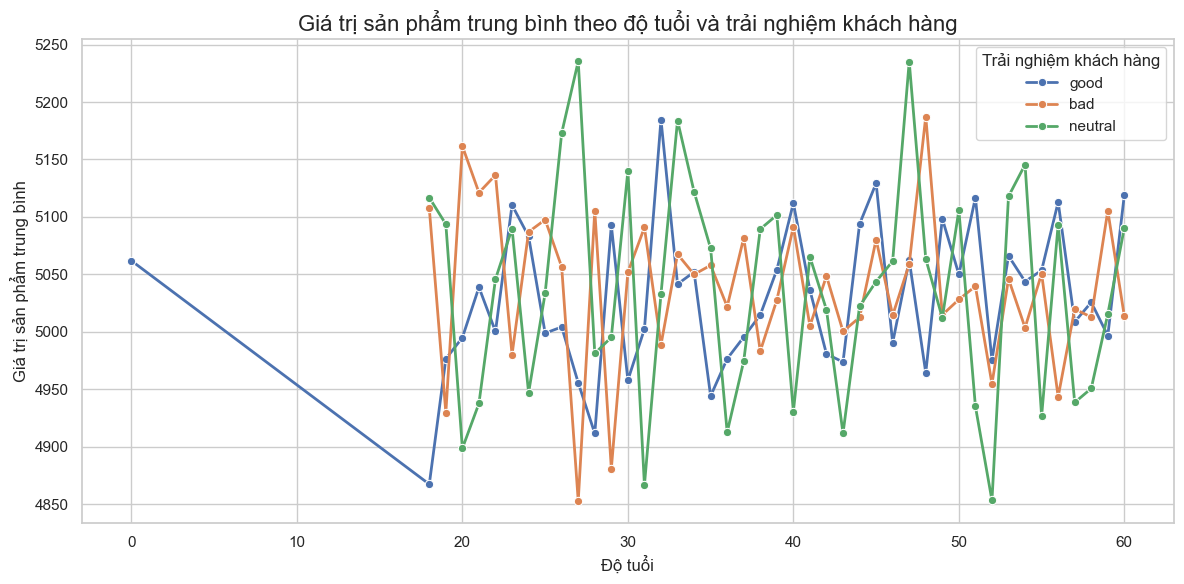

In [119]:
# Tính toán giá trị trung bình của 'Product_value' theo 'age' và 'customer_experience'
avg_product_value = df.groupby(['age', 'customer_experience'])['Product_value'].mean().reset_index()

# Vẽ biểu đồ đường
plt.figure(figsize=(12, 6))
sns.lineplot(x='age', y='Product_value', hue='customer_experience', data=avg_product_value, marker='o', linewidth=2)

# Thêm tiêu đề và nhãn cho trục
plt.title('Giá trị sản phẩm trung bình theo độ tuổi và trải nghiệm khách hàng', fontsize=16)
plt.xlabel('Độ tuổi', fontsize=12)
plt.ylabel('Giá trị sản phẩm trung bình', fontsize=12)

# Hiển thị biểu đồ
plt.legend(title='Trải nghiệm khách hàng')
plt.tight_layout()
plt.show()